# -------------------
# TIỀN XỬ LÝ DỮ LIỆU 
# -------------------

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
# Cấu hình đường dẫn
BASE_DIR = r'C:\Users\ADMIN\OneDrive\Documents\BTAPKPDL\cuoiki\code\archive'
CSV_PATH = os.path.join(BASE_DIR, 'metadata', 'UrbanSound8K.csv')
AUDIO_BASE_DIR = os.path.join(BASE_DIR, 'audio')

# Đọc metadata
df = pd.read_csv(CSV_PATH)
print("Metadata:")
print(df.head())

# Kiểm tra dữ liệu thiếu
missing_values = df.isnull().sum()
print("\nSố lượng giá trị thiếu:")
print(missing_values)

df = df.dropna().reset_index(drop=True)
print(f"\nĐã loại bỏ {missing_values.sum()} giá trị thiếu. Còn lại {len(df)} dòng dữ liệu.")



Metadata:
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  

Số lượng giá trị thiếu:
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

Đã loại bỏ 0 giá trị thiếu. Còn lại 8732 dòng dữ liệu.


In [3]:
# Kiểm tra file âm thanh có tồn tại không
def check_existing_files(df, audio_base_dir):
    def file_exists(row):
        fold = f"fold{row['fold']}"
        filename = row['slice_file_name']
        file_path = os.path.join(audio_base_dir, fold, filename)
        return os.path.isfile(file_path)
    
    df['file_exists'] = df.apply(file_exists, axis=1)
    return df[df['file_exists']].reset_index(drop=True)

df_exist = check_existing_files(df, AUDIO_BASE_DIR)
print(f"\n✅ Số lượng file âm thanh tồn tại: {len(df_exist)} / {len(df)}")


✅ Số lượng file âm thanh tồn tại: 8732 / 8732


In [4]:
# Chạy thử 1 file cụ thể
sample_audio_path = os.path.join(AUDIO_BASE_DIR, 'fold8', '4918-3-1-0.wav')
y_sample, sr_sample = librosa.load(sample_audio_path)
print(f"\n🎧 Sample file: {sample_audio_path}")
print(f"Sample rate: {sr_sample}, Duration: {len(y_sample)/sr_sample:.2f} sec")

# Phát audio
ipd.display(ipd.Audio(sample_audio_path))


🎧 Sample file: C:\Users\ADMIN\OneDrive\Documents\BTAPKPDL\cuoiki\code\archive\audio\fold8\4918-3-1-0.wav
Sample rate: 22050, Duration: 0.92 sec


In [5]:
 # Hàm load audio 
def load_audio(file_path, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr, mono=True)
        return y, sr
    except Exception as e:
        print(f"Lỗi khi load {file_path}: {e}")
        return None, None

In [6]:
# Xây dựng các hàm trích xuất đặc trưng 
def extract_mfcc(y, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

def extract_zcr(y):
    zero_crossings = np.where(np.diff(np.sign(y)))[0]
    return len(zero_crossings) / len(y)

def extract_rms(y):
    return np.sqrt(np.mean(np.square(y)))

def extract_audio_features(file_path):
    y, sr = load_audio(file_path)
    if y is None:
        return None
    try:
        mfcc = extract_mfcc(y, sr)
        zcr = extract_zcr(y)
        rms = extract_rms(y)
        return np.hstack([mfcc, zcr, rms])
    except Exception as e:
        print(f"Lỗi đặc trưng: {file_path} | {e}")
        return None

In [7]:
FEATURES_PATH = os.path.join(BASE_DIR, 'metadata', "extracted_features.csv")

if os.path.exists(FEATURES_PATH):
    print("📂 Đã có file đặc trưng, đọc lại...")
    df_features = pd.read_csv(FEATURES_PATH)
    features = df_features.drop(columns=['label']).values
    labels = df_features['label'].values
else:
    print("🛠️ Chưa có file đặc trưng, đang trích xuất...")
    
    def process_features(df_exist):
        features, labels = [], []
        for idx, row in df_exist.iterrows():
            fold = f"fold{row['fold']}"
            filename = row['slice_file_name']
            file_path = os.path.join(AUDIO_BASE_DIR, fold, filename)

            feat = extract_audio_features(file_path)
            if feat is not None:
                features.append(feat)
                labels.append(row['class'])
        return np.array(features), np.array(labels)

    features, labels = process_features(df_exist)

    df_features = pd.DataFrame(
        features,
        columns=[f'MFCC_{i+1}' for i in range(13)] + ['ZCR', 'RMS']
    )
    df_features['label'] = labels

    df_features.to_csv(FEATURES_PATH, index=False, encoding='utf-8-sig')
    print(f"✅ Đã lưu đặc trưng vào: {FEATURES_PATH}")

print("🧾 Một vài dòng dữ liệu đặc trưng:")
print(df_features.head())

📂 Đã có file đặc trưng, đọc lại...
🧾 Một vài dòng dữ liệu đặc trưng:
       MFCC_1      MFCC_2      MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -211.936981   62.581207 -122.813148 -60.745293 -13.893760 -29.789831   
1 -417.005188   99.336624  -42.995586  51.073326   9.853778   7.969693   
2 -452.393158  112.362534  -37.578068  43.195862   8.631845  15.379366   
3 -406.479218   91.196602  -25.043556  42.784519  11.586844   5.054164   
4 -439.638733  103.862228  -42.658787  50.690277  12.209422  15.873466   

      MFCC_7     MFCC_8     MFCC_9   MFCC_10   MFCC_11    MFCC_12    MFCC_13  \
0  -3.978875  11.682742  12.963828  8.336421 -6.529819  -2.996106 -12.887950   
1  11.197088   1.929117   7.030397  4.270228 -3.584726  13.890946  -2.764493   
2  16.882149   1.233047   6.833122  3.900115 -5.168849   8.300045   1.904139   
3  12.431632  -1.599948   6.656064  1.442355 -4.624870  14.211005   0.434271   
4  11.729268   1.533585  11.292244  2.548621 -7.290973  10.374461   2.101837   

     

In [8]:
# Mã hóa nhãn 
# Mặc dù trong file csv có nhãn rồi nma muốn kiểm soát thứ tự nhãn hoặc giải thích kết quả rõ hơn	
def encode_labels(labels):
    classes = sorted(set(labels))
    label_map = {label: idx for idx, label in enumerate(classes)}
    encoded = np.array([label_map[label] for label in labels])
    return encoded, label_map

labels_encoded, label_map = encode_labels(labels)
print("Mã hóa nhãn:")
print(pd.DataFrame({'label': labels_encoded}).head(10))
print("Các nhãn duy nhất:", np.unique(labels_encoded))

Mã hóa nhãn:
   label
0      3
1      2
2      2
3      2
4      2
5      2
6      2
7      2
8      2
9      1
Các nhãn duy nhất: [0 1 2 3 4 5 6 7 8 9]


In [9]:
# Chuẩn hóa đặc trưng 
def standardize_features(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std == 0] = 1
    return (X - mean) / std, mean, std

features_scaled, mean, std = standardize_features(features)

# Tạo DataFrame với dữ liệu đã chuẩn hóa
df_scaled = pd.DataFrame(features_scaled, columns=[f'MFCC_{i+1}' for i in range(13)] + ['ZCR', 'RMS'])
df_scaled['label'] = labels_encoded  

output_scaled_path = os.path.join(BASE_DIR, 'metadata', "standardized_features.csv")
df_scaled.to_csv(output_scaled_path, index=False, encoding='utf-8-sig')
print(f"Đã lưu đặc trưng chuẩn hóa vào file: {output_scaled_path}")
print("Sau chuẩn hóa:")
print(pd.DataFrame(features_scaled).head())

Đã lưu đặc trưng chuẩn hóa vào file: C:\Users\ADMIN\OneDrive\Documents\BTAPKPDL\cuoiki\code\archive\metadata\standardized_features.csv
Sau chuẩn hóa:
         0         1         2         3         4         5         6   \
0  0.096089 -0.875408 -3.219936 -3.488816 -0.543025 -2.663937 -0.256511   
1 -1.468548 -0.139458 -0.726405  1.828501  0.974632  0.066348  0.924365   
2 -1.738553  0.121358 -0.557159  1.453903  0.896541  0.602121  1.366733   
3 -1.388237 -0.302445 -0.165576  1.434343  1.085389 -0.144465  1.020428   
4 -1.641239 -0.048843 -0.715883  1.810286  1.125177  0.637848  0.965775   

         7         8         9         10        11        12        13  \
0  0.673114  1.597438  0.639745 -0.585947 -0.749000 -1.458570  0.115148   
1 -0.256469  1.000679  0.133003 -0.207648  1.514654 -0.013782  0.172394   
2 -0.322809  0.980838  0.086878 -0.411130  0.765212  0.652510 -0.213397   
3 -0.592811  0.963030 -0.219416 -0.341255  1.557557  0.442735  0.088200   
4 -0.294166  1.429317 -0

# ---------------------
# TRỰC QUAN HÓA DỮ LIỆU
# ---------------------

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_names, order=sorted_labels, palette=palette)


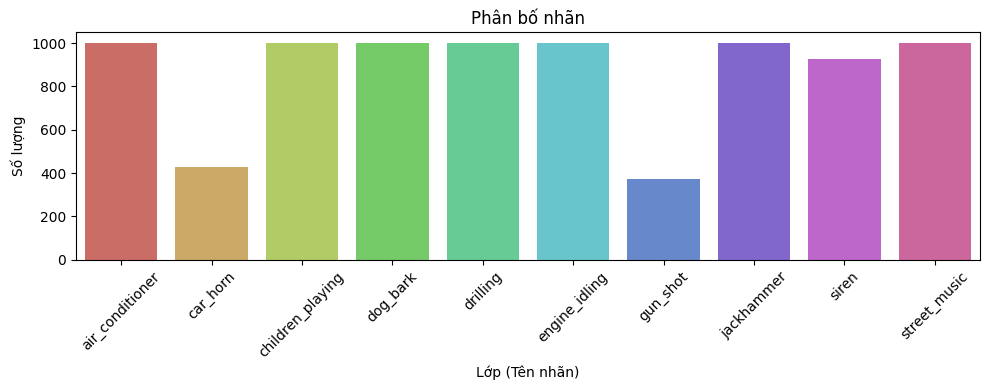

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


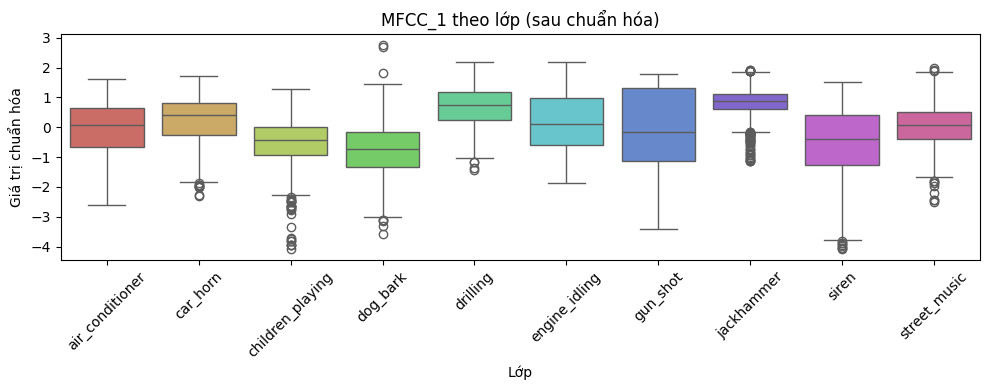

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


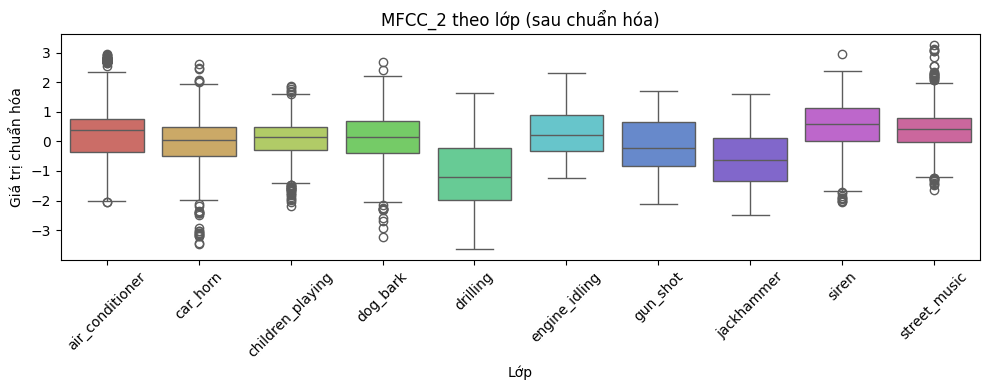

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


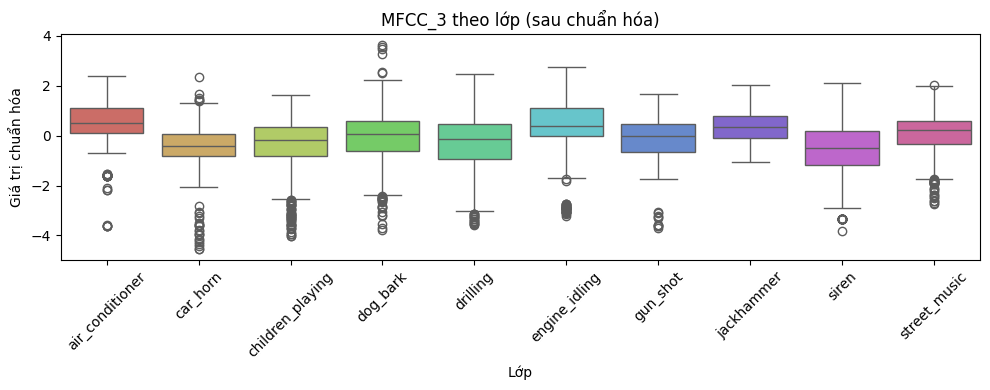

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


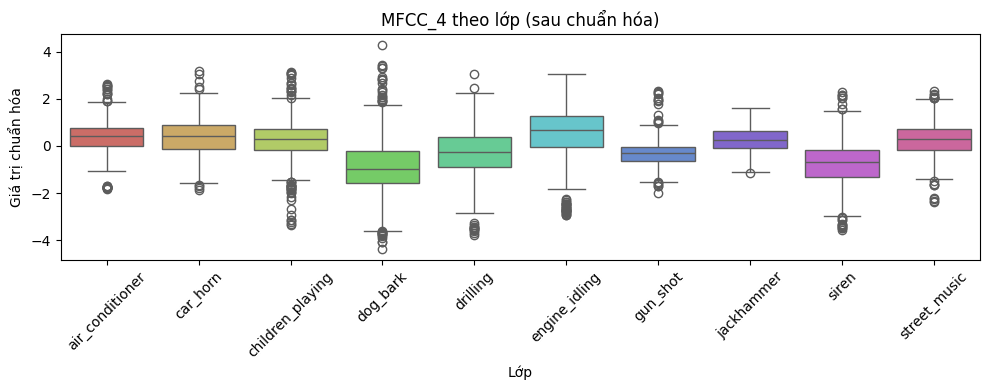

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


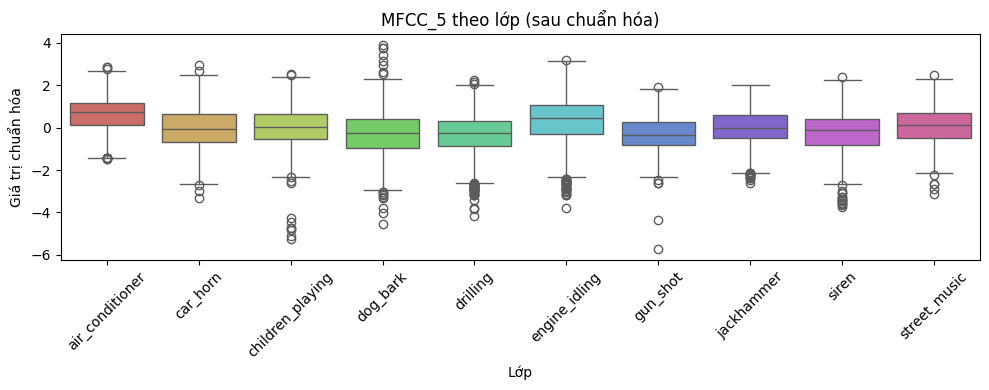

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


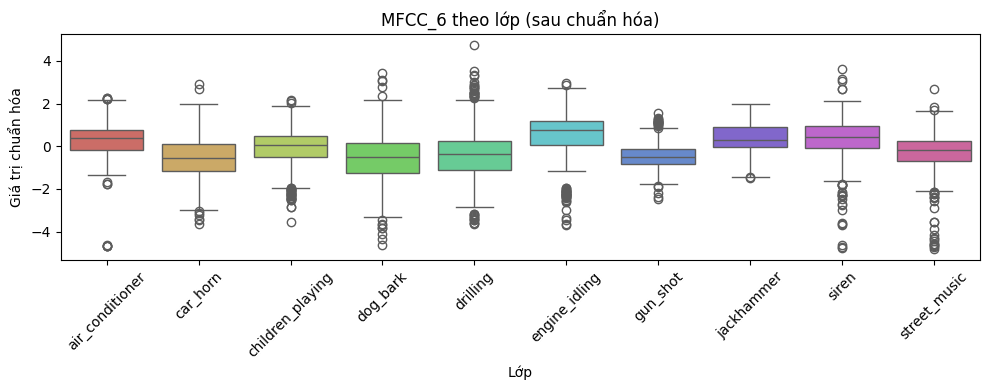

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


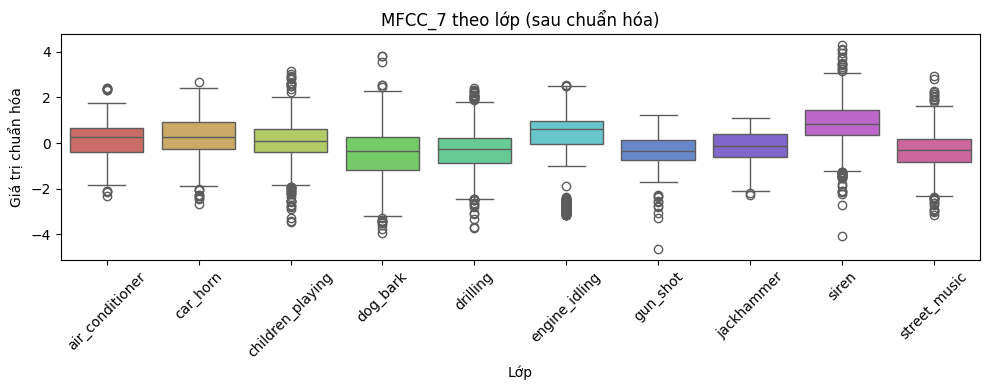

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


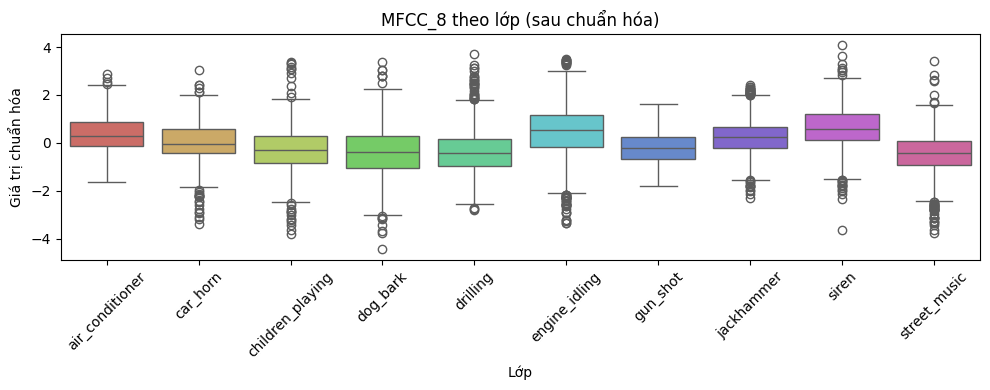

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


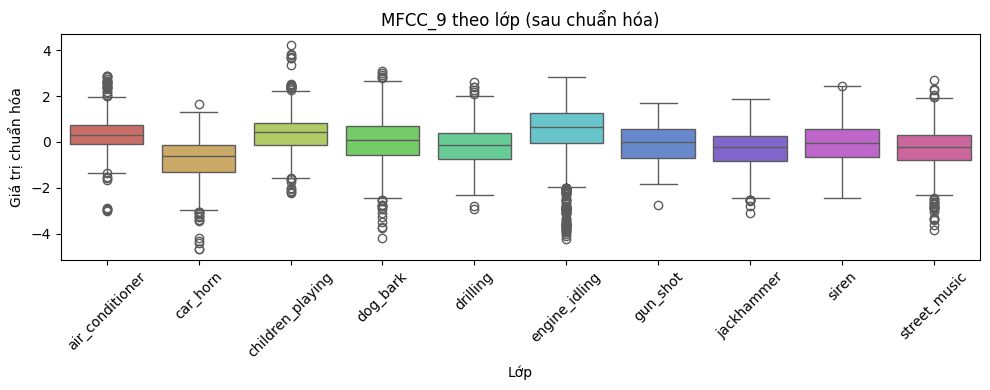

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


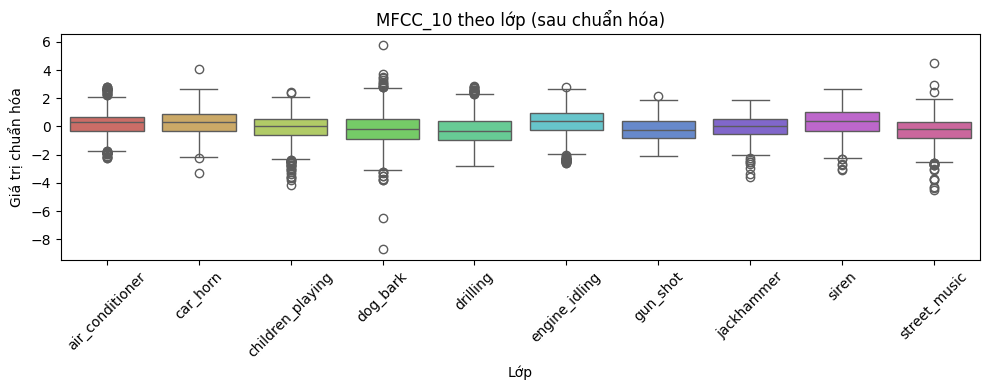

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


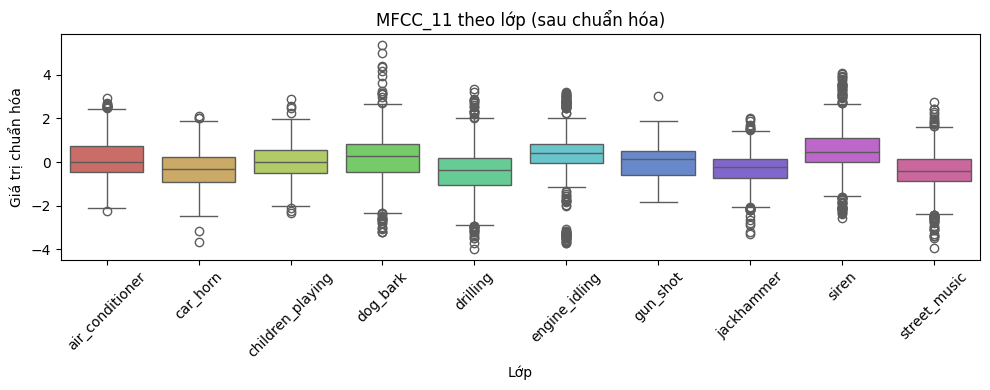

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


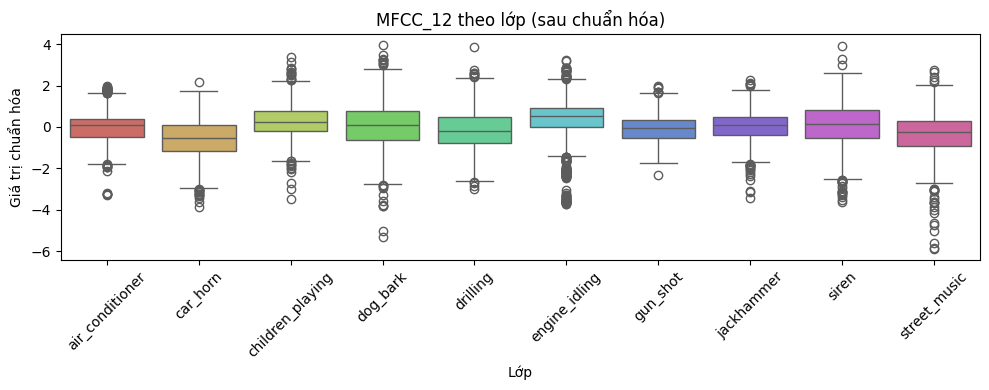

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


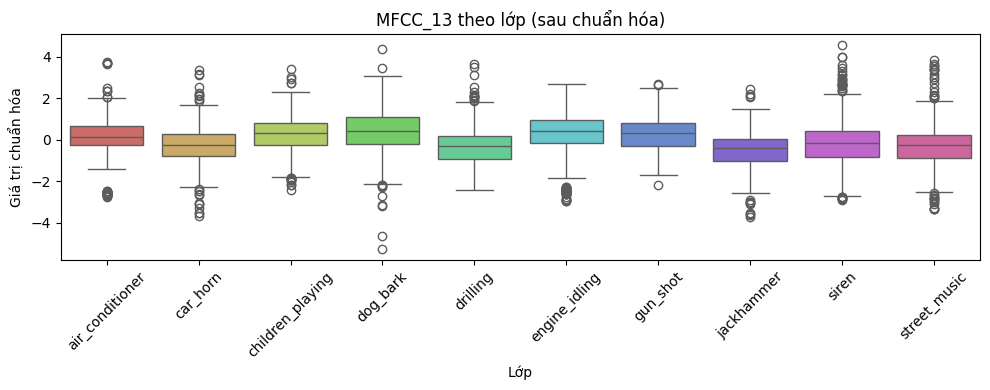

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


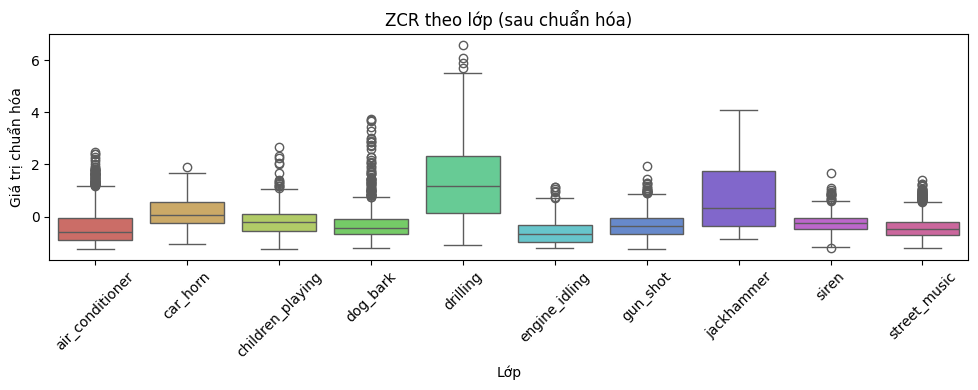

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10608\157777573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)


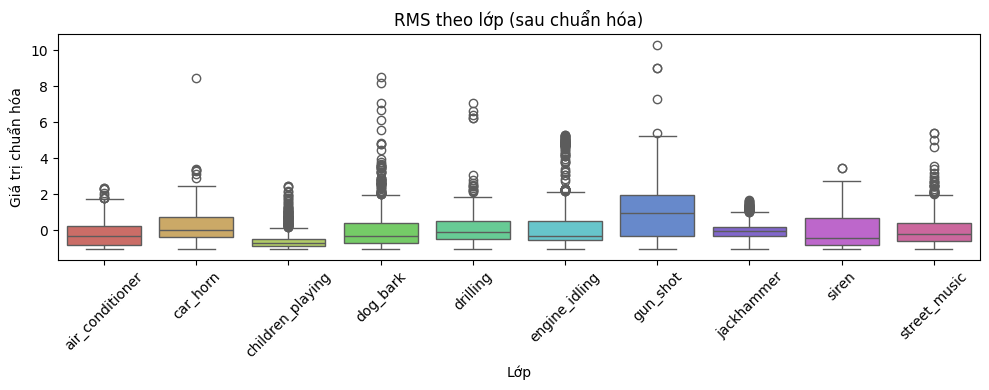

In [10]:
# Tạo bảng màu riêng cho từng nhãn
def create_label_palette(label_map):
    n_classes = len(label_map)
    palette = sns.color_palette("hls", n_classes)
    return {label: palette[i] for i, label in enumerate(label_map.keys())}

# Trực quan hóa phân bố nhãn
def plot_label_distribution(y_encoded, label_map, label_palette):
    id_to_label = {v: k for k, v in label_map.items()}
    label_names = [id_to_label[i] for i in y_encoded]
    sorted_labels = sorted(label_map.keys())
    palette = [label_palette[label] for label in sorted_labels]

    plt.figure(figsize=(10, 4))
    sns.countplot(x=label_names, order=sorted_labels, palette=palette)
    plt.title("Phân bố nhãn")
    plt.xlabel("Lớp (Tên nhãn)")
    plt.ylabel("Số lượng")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Vẽ boxplot cho từng đặc trưng
def plot_feature_by_class(feature_vector, labels, label_map, feature_name, label_palette):
    id_to_label = {v: k for k, v in label_map.items()}
    df_vis = pd.DataFrame({
        'feature': feature_vector,
        'label': [id_to_label[l] for l in labels]
    })

    sorted_labels = sorted(label_map.keys())
    palette = [label_palette[label] for label in sorted_labels]

    plt.figure(figsize=(10, 4))
    sns.boxplot(x='label', y='feature', data=df_vis, order=sorted_labels, palette=palette)
    plt.title(f'{feature_name} theo lớp (sau chuẩn hóa)')
    plt.xlabel("Lớp")
    plt.ylabel("Giá trị chuẩn hóa")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Vẽ MFCCs
def visualize_mfcc_features(features_scaled, labels, label_map, label_palette):
    for i in range(13):  
        feature_name = f'MFCC_{i+1}'
        plot_feature_by_class(features_scaled[:, i], labels, label_map, feature_name, label_palette)

# Vẽ ZCR và RMS
def visualize_zcr_rms(features_scaled, labels, label_map, label_palette):
    names = ['ZCR', 'RMS']
    indices = [13, 14]
    for name, idx in zip(names, indices):
        plot_feature_by_class(features_scaled[:, idx], labels, label_map, name, label_palette)
# -----------------------------
# Thực thi trực quan hóa
# -----------------------------

label_palette = create_label_palette(label_map)

plot_label_distribution(labels_encoded, label_map, label_palette)
visualize_mfcc_features(features_scaled, labels_encoded, label_map, label_palette)
visualize_zcr_rms(features_scaled, labels_encoded, label_map, label_palette)


# --------------
# THUẬT TOÁN KNN
# --------------

In [11]:
# Hàm khoảng cách Euclidean dùng ma trận
def euclidean_distance_matrix(X1, X2):
    X1 = np.array(X1)
    X2 = np.array(X2)
    X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
    X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
    cross = np.dot(X1, X2.T)
    return np.sqrt(X1_sq + X2_sq - 2 * cross)


# KNN thủ công dùng ma trận khoảng cách
class CustomKNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        distances = euclidean_distance_matrix(X_test, self.X_train)
        predictions = []
        for row in distances:
            k_idx = np.argsort(row)[:self.k]
            k_labels = self.y_train[k_idx]
            most_common = Counter(k_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return np.array(predictions)

# Tìm k tốt nhất
def find_best_k(X, y, k_values, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_k, best_acc = None, 0
    for k in k_values:
        acc_scores = []
        for train_idx, val_idx in skf.split(X, y):
            model = CustomKNN(k)
            model.fit(X[train_idx], y[train_idx])
            pred = model.predict(X[val_idx])
            acc_scores.append(accuracy_score(y[val_idx], pred))
        avg_acc = np.mean(acc_scores)
        print(f"K={k}, Accuracy={avg_acc:.4f}")
        if avg_acc > best_acc:
            best_k, best_acc = k, avg_acc
    return best_k

# ----------------------------------------------------
# TÌM K TỐI ƯU & HUẤN LUYỆN MÔ HÌNH CỦA THUẬT TOÁN KNN
# ----------------------------------------------------

In [12]:
k_range = range(2, 10)
best_k = find_best_k(features_scaled, labels_encoded, k_range)
print(f"\n K tối ưu là: {best_k}")

X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)
# In ra số lượng mẫu 
print(f"\n Số lượng mẫu:")
print(f"🔹 Tập train: {len(X_train)} mẫu")
print(f"🔹 Tập test : {len(X_test)} mẫu")

knn_model = CustomKNN(k=best_k)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

y_train_pred = knn_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"KNN Train Accuracy: {train_acc:.4f}")


print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred):.4f}")


K=2, Accuracy=0.9328
K=3, Accuracy=0.9149
K=4, Accuracy=0.9130
K=5, Accuracy=0.8933
K=6, Accuracy=0.8888
K=7, Accuracy=0.8704
K=8, Accuracy=0.8689
K=9, Accuracy=0.8533

 K tối ưu là: 2

 Số lượng mẫu:
🔹 Tập train: 6985 mẫu
🔹 Tập test : 1747 mẫu
KNN Train Accuracy: 0.9878

KNN Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.95      0.98      0.96       200
        car_horn       0.87      0.71      0.78        86
children_playing       0.89      0.94      0.91       200
        dog_bark       0.94      0.81      0.87       200
        drilling       0.94      0.93      0.93       200
   engine_idling       0.96      0.97      0.97       200
        gun_shot       0.84      0.87      0.86        75
      jackhammer       0.91      0.95      0.93       200
           siren       0.95      0.98      0.97       186
    street_music       0.86      0.91      0.88       200

        accuracy                           0.92      1747
  

# ---------------------------------------------------
# DỰ ĐOÁN FILE ÂM THANH MỚI TỪ NHẬP TÊN FILE & FOLDER
# ---------------------------------------------------

In [13]:
def predict_file(file_path):
    feat = extract_audio_features(file_path)
    if feat is None:
        return None, None
    feat_scaled = (feat - mean) / std
    pred_knn_encoded = knn_model.predict([feat_scaled])[0]
    inv_label_map = {v: k for k, v in label_map.items()}
    return inv_label_map[pred_knn_encoded], None  

selected_filename = input("\nNhập tên file .wav (ví dụ: 54898-8-0-2.wav): ")
selected_fold = input("Nhập số fold (ví dụ: 8): ")

example_file = os.path.join(AUDIO_BASE_DIR, f"fold{selected_fold}", selected_filename)

df_match = df[
    (df['fold'].astype(str) == str(selected_fold)) & 
    (df['slice_file_name'] == selected_filename)
]

print(f"\n📂 File: {example_file}")

if df_match.empty:
    print("  Không tìm thấy nhãn thật trong metadata.")
    pred_knn_label, _ = predict_file(example_file)
    print(f" Nhãn dự đoán : {pred_knn_label}")
else:
    selected_label = df_match['class'].values[0]
    pred_knn_label, _ = predict_file(example_file)
    print(f" Nhãn thật     : {selected_label}")
    print(f" Nhãn dự đoán : {pred_knn_label}")



📂 File: C:\Users\ADMIN\OneDrive\Documents\BTAPKPDL\cuoiki\code\archive\audio\fold7\518-4-0-0.wav
 Nhãn thật     : drilling
 Nhãn dự đoán : drilling


In [14]:
# DỰ ĐOÁN 1 FILE NGẪU NHIÊN TỪ TẬP TEST
# Lấy index thực tế trong df_exist tương ứng với tập test
def find_original_indices(X_all, X_subset):
    return [i for i, x in enumerate(X_all) if any((x == row).all() for row in X_subset)]

# Tìm chỉ số gốc của tập test trong toàn bộ dữ liệu
test_indices = find_original_indices(features_scaled, X_test)

# Chọn ngẫu nhiên 1 chỉ số từ tập test
random_idx = random.choice(test_indices)

# Lấy thông tin file từ metadata gốc
random_row = df_exist.iloc[random_idx]
selected_fold = random_row['fold']
selected_filename = random_row['slice_file_name']
selected_label = random_row['class']

# Đường dẫn đầy đủ đến file âm thanh
example_file = os.path.join(AUDIO_BASE_DIR, f"fold{selected_fold}", selected_filename)

# Hiển thị thông tin và dự đoán
print(f"\n File ngẫu nhiên từ tập test: {example_file}")
print(f" Nhãn thật     : {selected_label}")

pred_knn_label, _ = predict_file(example_file)
print(f" Nhãn dự đoán : {pred_knn_label}")

y_test_pred = knn_model.predict(X_test)
y_test_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test  

# Tính độ chính xác
knn_test_acc = accuracy_score(y_test_true, y_test_pred)
print(f"\n Độ chính xác của KNN trên tập test: {knn_test_acc:.4f}")


 File ngẫu nhiên từ tập test: C:\Users\ADMIN\OneDrive\Documents\BTAPKPDL\cuoiki\code\archive\audio\fold3\22601-8-0-53.wav
 Nhãn thật     : siren
 Nhãn dự đoán : siren

 Độ chính xác của KNN trên tập test: 0.9193


In [15]:
# Dự đoán file bên ngoài 
def predict_external_file(file_path):
    if not os.path.isfile(file_path):
        print(" File không tồn tại.")
        return
    print(f"\n Dự đoán cho file bên ngoài: {file_path}")
    ipd.display(ipd.Audio(file_path))

    feat = extract_audio_features(file_path)
    if feat is None:
        print(" Không thể trích xuất đặc trưng.")
        return

    feat_scaled = (feat - mean) / std
    pred_encoded = knn_model.predict([feat_scaled])[0]
    inv_label_map = {v: k for k, v in label_map.items()}
    predicted_label = inv_label_map[pred_encoded]

    print(f" Nhãn dự đoán: {predicted_label}")

# Nhập đường dẫn file ngoài
external_file = input("\nNhập đường dẫn file .wav ngoài: ")

if external_file.strip() != "":
    predict_external_file(external_file.strip())



 Dự đoán cho file bên ngoài: C:\Users\ADMIN\OneDrive\Documents\BTAPKPDL\cuoiki\code\archive\metadata\amthanhngoai\dog-barking-101729.mp3


 Nhãn dự đoán: dog_bark


# ---------------------------------------------------
# TRỰC QUAN HÓA KẾT QUẢ DỰ ĐOÁN VÀ ĐÁNH GIÁ MÔ HÌNH
# ---------------------------------------------------

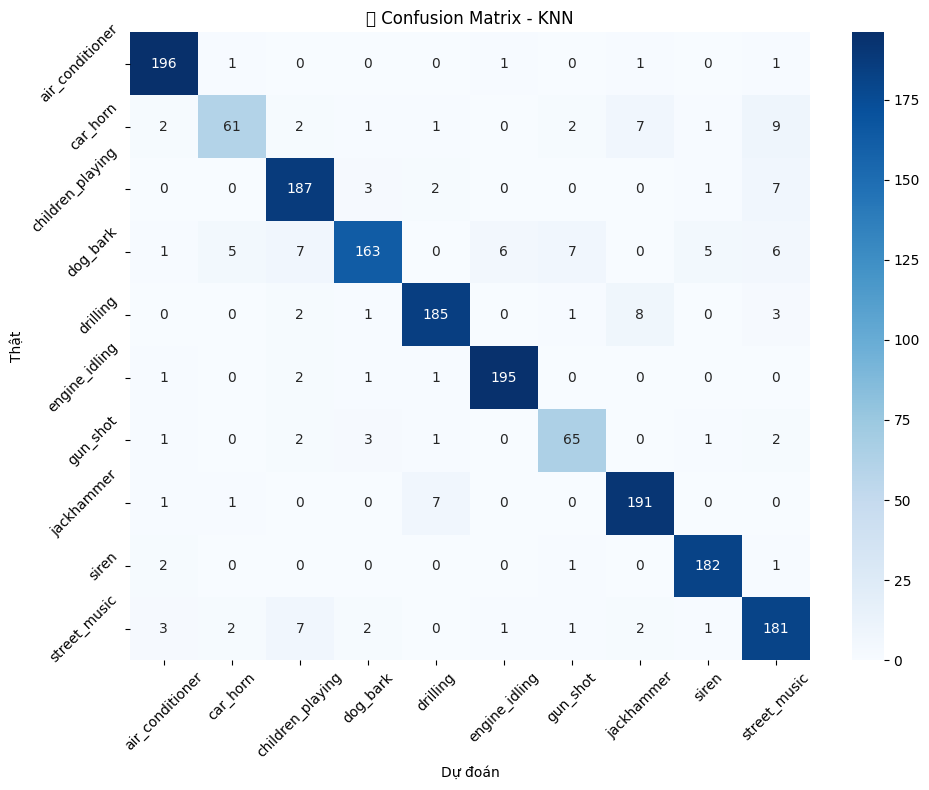

📋 Bảng đúng/sai theo lớp:
                  precision    recall  f1-score  correct  incorrect
air_conditioner    0.946860  0.980000  0.963145      196          4
car_horn           0.871429  0.709302  0.782051       61         25
children_playing   0.894737  0.935000  0.914425      187         13
dog_bark           0.936782  0.815000  0.871658      163         37
drilling           0.939086  0.925000  0.931990      185         15
engine_idling      0.960591  0.975000  0.967742      195          5
gun_shot           0.844156  0.866667  0.855263       65         10
jackhammer         0.913876  0.955000  0.933985      191          9
siren              0.952880  0.978495  0.965517      182          4
street_music       0.861905  0.905000  0.882927      181         19


<Figure size 1400x600 with 0 Axes>

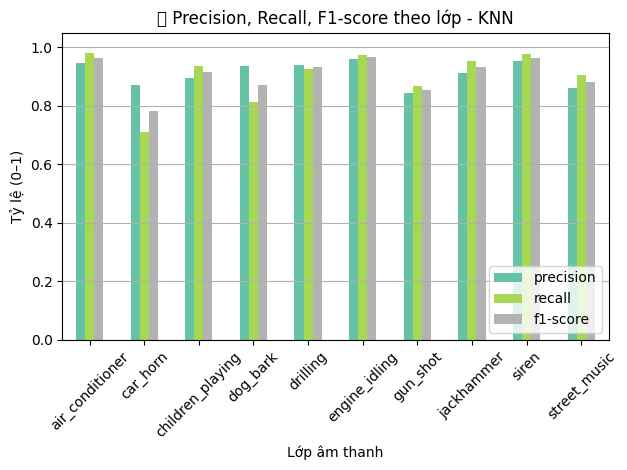

<Figure size 1400x600 with 0 Axes>

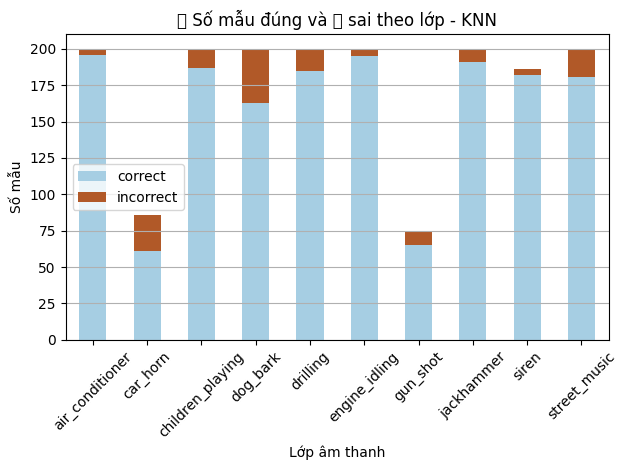

In [16]:
# 1. CONFUSION MATRIX 
cm = confusion_matrix(y_test, y_pred)

# Ánh xạ ID về tên nhãn
id_to_label = {v: k for k, v in label_map.items()}
labels_sorted = [id_to_label[i] for i in sorted(id_to_label.keys())]

# Vẽ confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap='Blues')
plt.title("🔍 Confusion Matrix - KNN")
plt.xlabel("Dự đoán")
plt.ylabel("Thật")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. CLASSIFICATION REPORT + ĐÚNG/SAI 
report_dict = classification_report(y_test, y_pred, target_names=labels_sorted, output_dict=True)
report_df = pd.DataFrame(report_dict).T.iloc[:-3]  # Bỏ macro/weighted avg

# Tính đúng / sai
correct = np.diag(cm)
total = np.sum(cm, axis=1)
incorrect = total - correct
report_df['correct'] = correct
report_df['incorrect'] = incorrect
report_df = report_df[['precision', 'recall', 'f1-score', 'correct', 'incorrect']]

# In bảng đúng sai 
print("📋 Bảng đúng/sai theo lớp:")
print(report_df)

#  3. BIỂU ĐỒ PRECISION / RECALL / F1 
plt.figure(figsize=(14, 6))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', colormap='Set2')
plt.title("🎯 Precision, Recall, F1-score theo lớp - KNN")
plt.xlabel("Lớp âm thanh")
plt.ylabel("Tỷ lệ (0–1)")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 4. BIỂU ĐỒ ĐÚNG / SAI 
plt.figure(figsize=(14, 6))
report_df[['correct', 'incorrect']].plot(kind='bar', stacked=True, colormap='Paired')
plt.title("✅ Số mẫu đúng và ❌ sai theo lớp - KNN")
plt.xlabel("Lớp âm thanh")
plt.ylabel("Số mẫu")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
